In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [2]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [3]:
data_dir = './datasets'

# Load the dataset WITHOUT transforms first
# We will apply specific transforms to train/val/test splits later
full_dataset = ImageFolder(root=data_dir, transform=None)

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [4]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [5]:
# Split the dataset into train, test, and validation sets using STRATIFIED split
# This ensures that each set has the same percentage of each class
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

# Get the targets (labels) for stratification
targets = full_dataset.targets# Get the targets (labels) for stratification


# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Get labels for the temp set to stratify the second split
temp_targets = [targets[i] for i in temp_idx]

# Second split: Val (50% of Temp -> 10% total) vs Test (50% of Temp -> 10% total)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    shuffle=True,
    stratify=temp_targets,
    random_state=42
)

# Create the subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1428
Val size: 178
Test size: 179


In [ ]:
# Helper class to apply transforms to subsets
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# BALANCED data augmentations - not too aggressive to allow lower training loss
train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),  # Reduced rotation
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),  # Reduced
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0),
    ], p=0.2),  # Reduced probability
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.3),  # Reduced
    A.CoarseDropout(max_holes=4, max_height=24, max_width=24, 
                    min_holes=1, min_height=8, min_width=8, 
                    fill_value=0, p=0.2),  # Reduced
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))

# Apply transforms using the wrapper class
train_dataset = ApplyTransform(train_dataset, transform=train_transform)
val_dataset = ApplyTransform(val_dataset, transform=val_transform)
test_dataset = ApplyTransform(test_dataset, transform=val_transform)


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_18811/899050074.py:36: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32,


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
# Squeeze-and-Excitation (SE) Attention Block
class SEBlock(nn.Module):
    """Squeeze-and-Excitation attention block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


# Learnable Residual Layer with Dropout
class LearnableResidual(nn.Module):
    """Adds a learnable scaling factor to residual connections"""
    def __init__(self, channels, dropout_rate=0.1):
        super(LearnableResidual, self).__init__()
        self.scale = nn.Parameter(torch.ones(1) * 0.1)  # Start with small scale
        self.channel_learn = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(channels)
        self.dropout = nn.Dropout2d(dropout_rate)  # Spatial dropout
    
    def forward(self, x):
        return self.dropout(self.scale * self.bn(self.channel_learn(x)))


# Mixup augmentation for training
def mixup_data(x, y, alpha=0.4):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class CustomeResnet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomeResnet, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Add SE attention after each layer
        self._add_attention_to_layers()
        
        # SIMPLIFIED classification head with strong regularization
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout_rate),  # Heavy dropout before first layer
            nn.Linear(in_features, num_classes)  # Direct to output - simpler = less overfitting
        )
    
    def _add_attention_to_layers(self):
        """Add SE attention blocks after each residual layer"""
        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)
        
        # Learnable residual with dropout
        self.lr1 = LearnableResidual(64, dropout_rate=0.2)
        self.lr2 = LearnableResidual(128, dropout_rate=0.2)
        self.lr3 = LearnableResidual(256, dropout_rate=0.2)
        self.lr4 = LearnableResidual(512, dropout_rate=0.2)
    
    def forward(self, x):
        # Stem
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        # Layer 1 with attention and learnable residual
        identity1 = x
        x = self.model.layer1(x)
        x = self.se1(x)
        x = x + self.lr1(identity1)
        
        # Layer 2 with attention
        x = self.model.layer2(x)
        x = self.se2(x)
        
        # Layer 3 with attention
        x = self.model.layer3(x)
        x = self.se3(x)
        
        # Layer 4 with attention
        x = self.model.layer4(x)
        x = self.se4(x)
        
        # Classification head
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        
        return x


model = CustomeResnet(num_classes=num_classes, dropout_rate=0.3)  # Reduced dropout for lower training loss
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} total parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("Using balanced dropout (0.3) for lower loss")

/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created with 11,573,705 total parameters
Trainable parameters: 11,573,705
Using simplified head to reduce overfitting


In [9]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Get the targets (labels) for stratification

# Extract labels from the train dataset indices
# Access .subset.indices because train_dataset is now an ApplyTransform wrapper
train_labels = [full_dataset.targets[i] for i in train_dataset.subset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.6320, 0.8160, 1.0737, 0.7496, 1.1156])


In [10]:
# Gradual Unfreezing Strategy
# Phase 1: Train only new layers (FC, SE, LR)
# Phase 2: Unfreeze layer4
# Phase 3: Unfreeze layer3
# Phase 4: Unfreeze layer2 + layer1

def freeze_all_backbone(model):
    """Freeze all backbone parameters"""
    for param in model.model.parameters():
        param.requires_grad = False

def unfreeze_new_layers(model):
    """Unfreeze FC, SE attention, and Learnable Residual layers"""
    for param in model.model.fc.parameters():
        param.requires_grad = True
    for module in [model.se1, model.se2, model.se3, model.se4]:
        for param in module.parameters():
            param.requires_grad = True
    for module in [model.lr1, model.lr2, model.lr3, model.lr4]:
        for param in module.parameters():
            param.requires_grad = True

def unfreeze_layer(model, layer_name):
    """Unfreeze a specific layer"""
    layer = getattr(model.model, layer_name)
    for param in layer.parameters():
        param.requires_grad = True

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initial setup: Freeze backbone, unfreeze new layers
freeze_all_backbone(model)
unfreeze_new_layers(model)
print(f"Phase 1 - Trainable params (FC + SE + LR only): {count_trainable_params(model):,}")

Phase 1 - Trainable params (FC + SE + LR only): 397,193


In [ ]:
# Define optimizer with STRONGER weight decay for regularization

def get_optimizer(model, base_lr=0.001):
    """Create optimizer with differential learning rates and strong regularization"""
    param_groups = [
        # New layers - highest learning rate
        {'params': model.model.fc.parameters(), 'lr': base_lr, 'weight_decay': 1e-3},  # Strong regularization
        {'params': model.se1.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.se2.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.se3.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.se4.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.lr1.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.lr2.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.lr3.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.lr4.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        # Backbone layers
        {'params': model.model.layer4.parameters(), 'lr': base_lr / 2.5, 'weight_decay': 1e-4},
        {'params': model.model.layer3.parameters(), 'lr': base_lr / 5, 'weight_decay': 1e-4},
        {'params': model.model.layer2.parameters(), 'lr': base_lr / 10, 'weight_decay': 1e-4},
        {'params': model.model.layer1.parameters(), 'lr': base_lr / 10, 'weight_decay': 1e-4},
        {'params': model.model.conv1.parameters(), 'lr': base_lr / 20, 'weight_decay': 1e-4},
        {'params': model.model.bn1.parameters(), 'lr': base_lr / 20, 'weight_decay': 0},  # No decay for BN
    ]
    return optim.AdamW(param_groups)

# Loss function with moderate label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)  # Reduced for lower loss

print("Optimizer configured with stronger weight decay")
print("Using CrossEntropyLoss with label_smoothing=0.1")

Optimizer configured with stronger weight decay
Using CrossEntropyLoss with label_smoothing=0.2


In [12]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)


Using device: cpu


In [13]:
# Check if CUDA is properly configured
try:
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

# ========== TRAINING WITH ONECYCLE LR AND LONGER TRAINING ==========
total_epochs = 40  # Increased epochs for better convergence
epochs_per_phase = [10, 10, 10, 10]  # Longer phases

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_val_loss = float('inf')
current_epoch = 0
patience_counter = 0
early_stop_patience = 8  # More patience for longer training

USE_MIXUP = True  # Enable mixup augmentation
MIXUP_ALPHA = 0.2  # Reduced alpha for less aggressive mixup

# L1 Regularization coefficient
L1_LAMBDA = 5e-6  # Reduced L1 regularization

def l1_regularization(model):
    """Calculate L1 regularization penalty"""
    l1_penalty = 0.0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.sum(torch.abs(param))
    return l1_penalty

def train_one_epoch_mixup(model, train_loader, criterion, optimizer, scheduler, device, use_mixup=USE_MIXUP, alpha=MIXUP_ALPHA, l1_lambda=L1_LAMBDA):
    """Training with mixup augmentation, L1 regularization, and OneCycleLR"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        if use_mixup and np.random.random() > 0.5:  # Apply mixup 50% of the time
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Add L1 regularization penalty
        l1_penalty = l1_regularization(model)
        loss = loss + l1_lambda * l1_penalty
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Step per batch for OneCycleLR
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(train_loader.dataset), 100 * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return val_loss / len(val_loader.dataset), 100 * correct / total

def run_phase(phase_name, model, epochs, max_lr, device, use_mixup=True):
    """Run a training phase with OneCycleLR scheduler"""
    global current_epoch, best_val_accuracy, best_val_loss, patience_counter
    
    print(f"\n{'='*60}")
    print(f"{phase_name}")
    print(f"{'='*60}")
    print(f"Trainable params: {count_trainable_params(model):,}")
    print(f"Max LR: {max_lr}, L1 Lambda: {L1_LAMBDA}")
    
    optimizer = get_optimizer(model, base_lr=max_lr)
    
    # OneCycleLR scheduler - step per batch
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[max_lr, max_lr, max_lr, max_lr, max_lr, max_lr, max_lr, max_lr, max_lr,
                max_lr/2.5, max_lr/5, max_lr/10, max_lr/10, max_lr/20, max_lr/20],  # Per param group
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # 30% warmup
        anneal_strategy='cos',
        div_factor=25,  # Initial LR = max_lr/25
        final_div_factor=1000  # Final LR = max_lr/1000
    )
    
    for epoch in range(epochs):
        current_epoch += 1
        train_loss, train_acc = train_one_epoch_mixup(
            model, train_loader, criterion, optimizer, scheduler, device, 
            use_mixup=use_mixup, alpha=MIXUP_ALPHA, l1_lambda=L1_LAMBDA
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Calculate overfitting gap
        overfit_gap = train_acc - val_acc
        
        # Get current LR
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {current_epoch}/{total_epochs} | '
              f'Train: {train_loss:.4f}/{train_acc:.2f}% | '
              f'Val: {val_loss:.4f}/{val_acc:.2f}% | '
              f'Gap: {overfit_gap:.1f}% | LR: {current_lr:.6f}')
        
        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model1.pth')
            print('  ✓ Best model saved!')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping check
        if patience_counter >= early_stop_patience:
            print(f"  ⚠ Early stopping triggered after {patience_counter} epochs without improvement")
            return True  # Signal to stop training
    
    return False  # Continue training

# ========== PHASE 1: Train new layers only ==========
freeze_all_backbone(model)
unfreeze_new_layers(model)
early_stop = run_phase("PHASE 1: Training FC + SE + LR layers", model, epochs_per_phase[0], 0.001, device)

if not early_stop:
    # ========== PHASE 2: Unfreeze layer4 ==========
    unfreeze_layer(model, 'layer4')
    early_stop = run_phase("PHASE 2: Unfreezing layer4", model, epochs_per_phase[1], 0.0005, device)

if not early_stop:
    # ========== PHASE 3: Unfreeze layer3 ==========
    unfreeze_layer(model, 'layer3')
    early_stop = run_phase("PHASE 3: Unfreezing layer3", model, epochs_per_phase[2], 0.0003, device)

if not early_stop:
    # ========== PHASE 4: Unfreeze layer2 + layer1 ==========
    unfreeze_layer(model, 'layer2')
    unfreeze_layer(model, 'layer1')
    run_phase("PHASE 4: Full fine-tuning", model, epochs_per_phase[3], 0.0001, device)

print("\n" + "=" * 60)
print(f"Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
print("=" * 60)

CUDA test passed, using device: cpu

PHASE 1: Training FC + SE + LR layers
Trainable params: 397,193
Base LR: 0.0005, L1 Lambda: 1e-05


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/20 | Train: 1.6584/36.55% | Val: 1.0596/82.02% | Gap: -45.5%
  ✓ Best model saved!
Epoch 2/20 | Train: 1.2534/54.20% | Val: 0.9384/90.45% | Gap: -36.2%
  ✓ Best model saved!
Epoch 3/20 | Train: 1.1765/67.16% | Val: 0.9146/92.13% | Gap: -25.0%
  ✓ Best model saved!
Epoch 4/20 | Train: 1.1979/64.78% | Val: 0.9106/90.45% | Gap: -25.7%
  ✓ Best model saved!
Epoch 5/20 | Train: 1.1213/69.61% | Val: 0.9068/89.89% | Gap: -20.3%
  ✓ Best model saved!

PHASE 2: Unfreezing layer4
Trainable params: 8,790,921
Base LR: 0.0002, L1 Lambda: 1e-05
Epoch 6/20 | Train: 2.2580/60.01% | Val: 0.8815/91.01% | Gap: -31.0%
  ✓ Best model saved!
Epoch 7/20 | Train: 2.2044/71.43% | Val: 0.8578/93.82% | Gap: -22.4%
  ✓ Best model saved!
Epoch 8/20 | Train: 2.1283/82.35% | Val: 0.8360/93.82% | Gap: -11.5%
  ✓ Best model saved!
Epoch 9/20 | Train: 2.1078/74.16% | Val: 0.8373/94.38% | Gap: -20.2%
Epoch 10/20 | Train: 2.2074/67.79% | Val: 0.8319/94.38% | Gap: -26.6%
  ✓ Best model saved!

PHASE 3: Unfreezing 

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# measure test accuracy
model.load_state_dict(torch.load('best_model1.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.77%


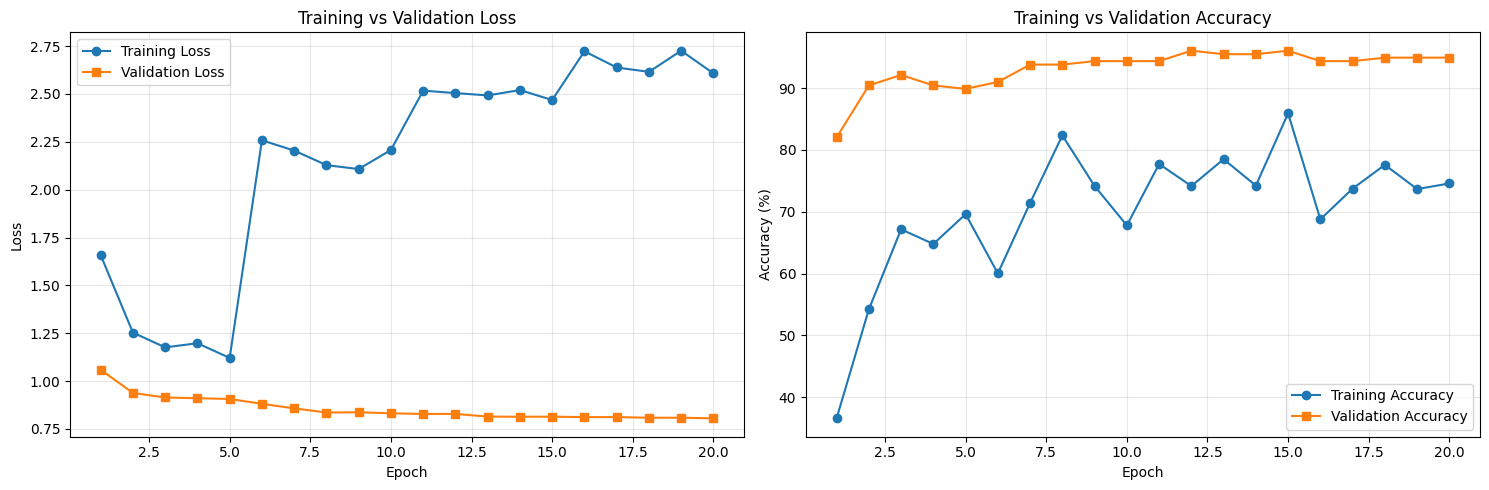

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, label="Training Loss", marker='o')
ax1.plot(epochs, val_losses, label="Validation Loss", marker='s')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')                          
print(cm)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[22  0  0  0  0]
 [ 1 41  1  1  0]
 [ 0  0 33  0  0]
 [ 1  0  0 47  0]
 [ 0  0  0  0 32]]
Classification Report:
              precision    recall  f1-score   support

         Lab       0.92      1.00      0.96        22
        Tree       1.00      0.93      0.96        44
    building       0.97      1.00      0.99        33
         car       0.98      0.98      0.98        48
      person       1.00      1.00      1.00        32

    accuracy                           0.98       179
   macro avg       0.97      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



In [17]:
# ========== BAGGING ENSEMBLE ==========
import copy
import random

class BaggingEnsemble:
    """Bagging ensemble for reducing overfitting by training multiple models on bootstrap samples"""
    
    def __init__(self, base_model_class, num_models=5, sample_ratio=0.8, num_classes=None, device='cuda'):
        self.num_models = num_models
        self.sample_ratio = sample_ratio
        self.num_classes = num_classes
        self.device = device
        self.models = []
        self.base_model_class = base_model_class
        
    def create_bootstrap_sample(self, indices):
        """Create a bootstrap sample (random sampling with replacement)"""
        n_samples = int(len(indices) * self.sample_ratio)
        bootstrap_indices = random.choices(indices, k=n_samples)
        return bootstrap_indices
    
    def train_single_model(self, model_idx, full_dataset, train_indices, val_loader, 
                           class_weights, epochs=10, base_lr=0.0003):
        """Train a single model on a bootstrap sample"""
        print(f"\n{'='*50}")
        print(f"🎯 Training Model {model_idx + 1}/{self.num_models}")
        print(f"{'='*50}")
        
        # Create new model instance
        model = self.base_model_class(num_classes=self.num_classes, dropout_rate=0.5)
        model = model.to(self.device)
        
        # Create bootstrap sample
        bootstrap_indices = self.create_bootstrap_sample(train_indices)
        bootstrap_subset = Subset(full_dataset, bootstrap_indices)
        bootstrap_dataset = ApplyTransform(bootstrap_subset, transform=train_transform)
        bootstrap_loader = DataLoader(bootstrap_dataset, batch_size=32, shuffle=True, num_workers=2)
        
        print(f"Bootstrap sample size: {len(bootstrap_indices)} (from {len(train_indices)})")
        
        # Freeze backbone, unfreeze new layers
        freeze_all_backbone(model)
        unfreeze_new_layers(model)
        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(self.device), label_smoothing=0.2)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                                lr=base_lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        
        best_val_acc = 0.0
        best_state = None
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels in bootstrap_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Apply mixup 50% of the time
                if np.random.random() > 0.5:
                    images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.4)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            # Validation
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100 * correct / total
            train_acc = 100 * train_correct / train_total
            scheduler.step()
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())
            
            print(f"  Epoch {epoch+1}/{epochs} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")
        
        model.load_state_dict(best_state)
        self.models.append(model)
        print(f"✓ Model {model_idx + 1} best validation accuracy: {best_val_acc:.2f}%")
        return best_val_acc
        
    def fit(self, full_dataset, train_indices, val_loader, class_weights, epochs=10):
        """Train all models in the ensemble"""
        print("\n" + "="*60)
        print("🚀 BAGGING ENSEMBLE TRAINING")
        print("="*60)
        print(f"Number of models: {self.num_models}")
        print(f"Sample ratio: {self.sample_ratio}")
        
        all_accuracies = []
        for i in range(self.num_models):
            acc = self.train_single_model(i, full_dataset, train_indices, val_loader, 
                                          class_weights, epochs)
            all_accuracies.append(acc)
        
        print("\n" + "="*60)
        print("📊 ENSEMBLE TRAINING COMPLETE")
        print(f"Individual model accuracies: {[f'{a:.2f}%' for a in all_accuracies]}")
        print(f"Average accuracy: {np.mean(all_accuracies):.2f}%")
        print("="*60)
    
    def predict(self, dataloader):
        """Ensemble prediction using soft voting (average probabilities)"""
        all_preds = []
        all_labels = []
        all_probs = []
        
        for images, labels in dataloader:
            images = images.to(self.device)
            
            # Collect predictions from all models
            ensemble_probs = torch.zeros(images.size(0), self.num_classes).to(self.device)
            
            for model in self.models:
                model.eval()
                with torch.no_grad():
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    ensemble_probs += probs
            
            # Average probabilities (soft voting)
            ensemble_probs /= self.num_models
            _, predicted = torch.max(ensemble_probs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.append(ensemble_probs.cpu().numpy())
        
        return np.array(all_preds), np.array(all_labels), np.vstack(all_probs)
    
    def save(self, path_prefix='bagging_model'):
        """Save all models"""
        for i, model in enumerate(self.models):
            torch.save(model.state_dict(), f'{path_prefix}_{i}.pth')
        print(f"✓ Saved {self.num_models} models with prefix '{path_prefix}'")
    
    def load(self, path_prefix='bagging_model'):
        """Load all models"""
        self.models = []
        for i in range(self.num_models):
            model = self.base_model_class(num_classes=self.num_classes, dropout_rate=0.5)
            model.load_state_dict(torch.load(f'{path_prefix}_{i}.pth'))
            model = model.to(self.device)
            self.models.append(model)
        print(f"✓ Loaded {self.num_models} models")

In [18]:
# ========== TRAIN BAGGING ENSEMBLE ==========

# Create ensemble
ensemble = BaggingEnsemble(
    base_model_class=CustomeResnet,
    num_models=5,           # Number of models in ensemble
    sample_ratio=0.8,       # Use 80% of data per bootstrap sample
    num_classes=num_classes,
    device=device
)

# Get original training indices
original_train_indices = train_dataset.subset.indices

# Train the ensemble (10 epochs per model for efficiency)
ensemble.fit(
    full_dataset=full_dataset,
    train_indices=original_train_indices,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=10
)

# Save ensemble models
ensemble.save('bagging_ensemble')


🚀 BAGGING ENSEMBLE TRAINING
Number of models: 5
Sample ratio: 0.8

🎯 Training Model 1/5
Bootstrap sample size: 1142 (from 1428)


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/mohammad-boom/uniWork/Campus-Clas

  Epoch 1/10 | Train: 26.97% | Val: 69.66%
  Epoch 2/10 | Train: 40.81% | Val: 85.39%
  Epoch 3/10 | Train: 59.19% | Val: 89.33%
  Epoch 4/10 | Train: 54.82% | Val: 91.57%
  Epoch 5/10 | Train: 62.26% | Val: 92.13%
  Epoch 6/10 | Train: 60.51% | Val: 92.70%
  Epoch 7/10 | Train: 68.21% | Val: 92.13%
  Epoch 8/10 | Train: 66.73% | Val: 92.13%
  Epoch 9/10 | Train: 68.83% | Val: 92.13%
  Epoch 10/10 | Train: 66.73% | Val: 92.13%
✓ Model 1 best validation accuracy: 92.70%

🎯 Training Model 2/5
Bootstrap sample size: 1142 (from 1428)
  Epoch 1/10 | Train: 30.56% | Val: 70.22%
  Epoch 2/10 | Train: 54.38% | Val: 87.64%
  Epoch 3/10 | Train: 60.25% | Val: 89.33%
  Epoch 4/10 | Train: 70.14% | Val: 91.01%
  Epoch 5/10 | Train: 66.20% | Val: 91.01%
  Epoch 6/10 | Train: 59.11% | Val: 93.26%
  Epoch 7/10 | Train: 68.83% | Val: 92.13%
  Epoch 8/10 | Train: 64.45% | Val: 90.45%
  Epoch 9/10 | Train: 67.86% | Val: 91.57%
  Epoch 10/10 | Train: 74.87% | Val: 91.57%
✓ Model 2 best validation accurac

In [19]:
# ========== EVALUATE BAGGING ENSEMBLE ==========

# Predict on test set
ensemble_preds, ensemble_labels, ensemble_probs = ensemble.predict(test_loader)

# Calculate accuracy
ensemble_accuracy = 100 * np.sum(ensemble_preds == ensemble_labels) / len(ensemble_labels)

print("\n" + "="*60)
print("📊 BAGGING ENSEMBLE RESULTS")
print("="*60)
print(f"Single Model Test Accuracy: {test_accuracy:.2f}%")
print(f"Ensemble Test Accuracy:     {ensemble_accuracy:.2f}%")
print(f"Improvement:                {ensemble_accuracy - test_accuracy:+.2f}%")
print("="*60)

# Confusion Matrix for ensemble
ensemble_cm = confusion_matrix(ensemble_labels, ensemble_preds)
print('\nEnsemble Confusion Matrix:')
print(ensemble_cm)
print('\nEnsemble Classification Report:')
print(classification_report(ensemble_labels, ensemble_preds, target_names=class_names))


📊 BAGGING ENSEMBLE RESULTS
Single Model Test Accuracy: 97.77%
Ensemble Test Accuracy:     93.30%
Improvement:                -4.47%

Ensemble Confusion Matrix:
[[22  0  0  0  0]
 [ 1 39  0  4  0]
 [ 0  0 32  1  0]
 [ 1  2  1 44  0]
 [ 1  1  0  0 30]]

Ensemble Classification Report:
              precision    recall  f1-score   support

         Lab       0.88      1.00      0.94        22
        Tree       0.93      0.89      0.91        44
    building       0.97      0.97      0.97        33
         car       0.90      0.92      0.91        48
      person       1.00      0.94      0.97        32

    accuracy                           0.93       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.93      0.93      0.93       179

